Image Classification with Transfer Learning on **CIFAR-10** dataset and **vgg16** model




In [3]:
import os
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from keras import optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.applications import vgg16 as vgg

Using TensorFlow backend.


In [0]:
batch_size = 512
num_classes = 10
epochs = 50
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [5]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [0]:

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [0]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

In [0]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [0]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(64, activation='relu')(x)
pred = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, pred)

In [11]:
# model.get_layer('block1_conv1').trainable = False
# model.get_layer('block1_conv2').trainable = False
# model.get_layer('block2_conv1').trainable = False
# model.get_layer('block2_conv2').trainable = False
# model.get_layer('block3_conv1').trainable = False
# model.get_layer('block3_conv2').trainable = False
# model.get_layer('block3_conv3').trainable = False

for l in model.layers:
    print(l.name, l.trainable)

input_1 False
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
global_average_pooling2d_1 True
batch_normalization_1 True
dense_1 True
dropout_1 True
dense_2 True
dense_3 True


In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [0]:
LEARNING_RATE = .00001#1e-4
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [0]:
stop_callbacks = [              
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5),
]

In [15]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.1,  # set range for random shear
    zoom_range=0.1,  # set range for random zoom
    channel_shift_range=0.2,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(
          datagen.flow(x_train, 
                      y_train,
                      batch_size=batch_size),
          epochs=epochs,
          validation_data=(x_test, y_test),
          workers=4,
          callbacks=stop_callbacks)



Using real-time data augmentation.
Epoch 1/50
98/98 [==============================] - 42s 426ms/step - loss: 0.2526 - accuracy: 0.9061 - val_loss: 0.3596 - val_accuracy: 0.8672
Epoch 2/50
98/98 [==============================] - 40s 412ms/step - loss: 0.1956 - accuracy: 0.9235 - val_loss: 0.5773 - val_accuracy: 0.8727
Epoch 3/50
98/98 [==============================] - 40s 413ms/step - loss: 0.1700 - accuracy: 0.9339 - val_loss: 0.3313 - val_accuracy: 0.8940
Epoch 4/50
98/98 [==============================] - 40s 413ms/step - loss: 0.1517 - accuracy: 0.9413 - val_loss: 0.2258 - val_accuracy: 0.9183
Epoch 5/50
98/98 [==============================] - 40s 413ms/step - loss: 0.1388 - accuracy: 0.9464 - val_loss: 0.1360 - val_accuracy: 0.9472
Epoch 6/50
98/98 [==============================] - 41s 415ms/step - loss: 0.1298 - accuracy: 0.9498 - val_loss: 0.1638 - val_accuracy: 0.9374
Epoch 7/50
98/98 [==============================] - 41s 414ms/step - loss: 0.1221 - accuracy: 0.9531 - val_

In [16]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 


In [17]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 185us/step
Test loss: 0.09051128251552581
Test accuracy: 0.9733396768569946


In [0]:
CLASSES = np.array([
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
])
predictions = model.predict(x=x_test)
predictions_single = CLASSES[np.argmax(predictions, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

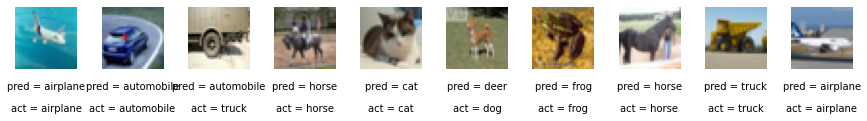

In [26]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(predictions_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)